In [1]:
%run "C:\Users\puzheng\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

45044


# 0. required packages for h5py

In [9]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08',
             'save_folder':r'W:\Pu_Temp\20201215-proB_dox-iaa-sti+',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210203-Corrections_3color_35',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(4,54)

In [4]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 200

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.5, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2483.47s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_04.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_04.dax  in 4.793s
-- removing hot pixels for channels:['750'] in 9.327s
-- illumination correction for channels: 750, in 1.822s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.606s
-- finish correction in 123.006s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

C:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 348 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 216.435s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_04.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.030s.
+ loading unique from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_04.hdf5
++ finish loading unique in 0.035s. 
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_04.hdf5


C:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ base attributes loaded:[] in 0.952s.
- start select from 348 chromosomes with loss threshold=0.5
-- remove chr id 15, percentage of lost rounds:0.785.
-- remove chr id 74, percentage of lost rounds:0.694.
-- remove chr id 99, percentage of lost rounds:0.646.
-- remove chr id 68, percentage of lost rounds:0.639.
-- remove chr id 95, percentage of lost rounds:0.639.
-- remove chr id 170, percentage of lost rounds:0.639.
-- remove chr id 196, percentage of lost rounds:0.639.
-- remove chr id 267, percentage of lost rounds:0.632.
-- remove chr id 128, percentage of lost rounds:0.625.
-- remove chr id 128, percentage of lost rounds:0.625.
-- remove chr id 158, percentage of lost rounds:0.625.
-- remove chr id 243, percentage of lost rounds:0.625.
-- remove chr id 251, percentage of lost rounds:0.625.
-- remove chr id 148, percentage of lost rounds:0.583.
-- remove chr id 198, percentage of lost rounds:0.549.
-- remove chr id 68, percentage of lost rounds:0.521.
-- remove chr id 103, perc

-- checking unique, region:[ 99 100 101] in 0.010s.
-- checking unique, region:[102 103 104] in 0.009s.
-- checking unique, region:[105 106 107] in 0.009s.
-- checking unique, region:[108 109 110] in 0.009s.
+ Start multi-processing of pre-processing for 50 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2525.50s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chroma

-- saving 750_647_561_bleed profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_06.hdf5.
-- saving unique to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_06.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.010s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_06.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.030s.
-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IA

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_07.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_07.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_07.dax  in 5.034s
-- removing hot pixels for channels:['750'] in 9.282s
-- illumination correction for channels: 750, in 1.801s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.919s
-- finish correction in 127.820s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_07.hdf5
++ base attributes saved:['chrom_im'] in 20.359s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_07.hdf5
++ base attributes loaded:[] in 0.883s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segme

++ base attributes saved:['ref_im'] in 16.261s.
-- checking unique, region:[41 42 43] in 0.012s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.009s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.009s.
-- checking unique, region:[60 61 62] in 0.009s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in 0.009s.
-- checking unique, region:[75 76 77] in 0.009s.
-- checking unique, region:[78 79 80] in 0.009s.
-- checking unique, region:[81 82 83] in 0.009s.
-- checking unique, region:[84 85 86] in 0.009s.
-- checking unique, region:[87 88 89] in 0.009s.
-- checking unique, region:[90 91 92] in 0.009s.
-- checking unique, region:[93 94 95] in 0.009s.
-- checking unique, region:[323 321 328] in 0.009s.
-- checking unique

-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09

-- remove chr id 186, percentage of lost rounds:0.597.
-- remove chr id 17, percentage of lost rounds:0.562.
-- remove chr id 98, percentage of lost rounds:0.542.
-- 216 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_09.hdf5
++ base attributes saved:['chrom_coords'] in 0.111s.
kept chromosomes: 216
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from f

+ Start multi-processing of pre-processing for 50 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2419.14s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_10.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_11.dax  in 4.574s
-- removing hot pixels for channels:['488'] in 9.233s
-- illumination correction for channels: 488, in 1.800s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 16.081s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_11.hdf5
++ base attributes saved:['ref_im'] in 15.906s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.009s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.009s.
-- checking unique, region:[60 61 62] in 0.009s.
-- checking unique, region:[63 64 65] in 0.010s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in

	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_12.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.026s.
-- saving segmentation to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
-- saving co

++ base attributes saved:['chrom_im'] in 21.030s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
++ base attributes loaded:[] in 0.878s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 304 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 179.618s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.038s.
+ loading unique from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
++ finish loading unique in 0.033s. 
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_12.hdf5
++ base attributes loaded:[] in 0.971s.
- start select from 304 chromosomes with loss threshold=0.5
-- remove chr id 300, percen

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_13.dax  in 4.442s
-- removing hot pixels for channels:['488'] in 9.246s
-- illumination correction for channels: 488, in 1.780s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 15.935s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_13.hdf5
++ base attributes saved:['ref_im'] in 17.847s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.009s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.009s.
-- checking unique, region:[53 54 55] in 0.111s.
-- checking unique, region:[56 57 59] in 0.010s.
-- checking unique, region:[60 61 62] in 0.010s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_14.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.026s.
-- saving segmentation to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
-- saving correction to file: W:\Pu_Temp\20201215-proB_dox-i

++ base attributes saved:['chrom_im'] in 19.375s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
++ base attributes loaded:[] in 1.078s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 367 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 214.328s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.030s.
+ loading unique from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
++ finish loading unique in 0.034s. 
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_14.hdf5
++ base attributes loaded:[] in 0.938s.
- start select from 367 chromosomes with loss threshold=0.5
-- remove chr id 74, percent

-- checking unique, region:[351 349 359] in 0.009s.
-- checking unique, region:[354 352 362] in 0.010s.
-- checking unique, region:[357 355 365] in 0.009s.
-- checking unique, region:[360 358 368] in 0.009s.
-- checking unique, region:[363 361 371] in 0.009s.
-- checking unique, region:[366 364 374] in 0.010s.
-- checking unique, region:[369 367 377] in 0.009s.
-- checking unique, region:[372 370 381] in 0.009s.
-- checking unique, region:[375 373 384] in 0.009s.
-- checking unique, region:[379 376 387] in 0.010s.
-- checking unique, region:[382 380 390] in 0.009s.
-- checking unique, region:[388 383 393] in 0.009s.
-- checking unique, region:[391 386] in 0.008s.
-- checking unique, region:[394 389] in 0.008s.
-- checking unique, region:[392] in 0.008s.
-- checking unique, region:[395] in 0.008s.
-- checking unique, region:[111 112 113] in 0.009s.
-- checking unique, region:[114 115 325] in 0.009s.
-- checking unique, region:[96 97 98] in 0.009s.
-- checking unique, region:[ 99 100 101

-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16

-- remove chr id 89, percentage of lost rounds:0.611.
-- remove chr id 193, percentage of lost rounds:0.611.
-- remove chr id 22, percentage of lost rounds:0.590.
-- remove chr id 85, percentage of lost rounds:0.590.
-- remove chr id 216, percentage of lost rounds:0.590.
-- remove chr id 242, percentage of lost rounds:0.590.
-- remove chr id 38, percentage of lost rounds:0.576.
-- remove chr id 242, percentage of lost rounds:0.576.
-- remove chr id 264, percentage of lost rounds:0.556.
-- remove chr id 231, percentage of lost rounds:0.535.
-- remove chr id 184, percentage of lost rounds:0.528.
-- remove chr id 166, percentage of lost rounds:0.521.
-- remove chr id 135, percentage of lost rounds:0.507.
-- 284 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_16.hdf5
++ base attributes saved:['chrom_coords'] in 0.117s.
kept chromosomes: 284
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 

-- checking unique, region:[392] in 0.008s.
-- checking unique, region:[395] in 0.008s.
-- checking unique, region:[111 112 113] in 0.010s.
-- checking unique, region:[114 115 325] in 0.013s.
-- checking unique, region:[96 97 98] in 0.009s.
-- checking unique, region:[ 99 100 101] in 0.009s.
-- checking unique, region:[102 103 104] in 0.010s.
-- checking unique, region:[105 106 107] in 0.009s.
-- checking unique, region:[108 109 110] in 0.009s.
+ Start multi-processing of pre-processing for 50 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 36

-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5.
-- saving 750_647_561_bleed profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_1

-- remove chr id 179, percentage of lost rounds:0.597.
-- remove chr id 165, percentage of lost rounds:0.583.
-- remove chr id 120, percentage of lost rounds:0.569.
-- remove chr id 179, percentage of lost rounds:0.569.
-- remove chr id 90, percentage of lost rounds:0.556.
-- remove chr id 64, percentage of lost rounds:0.542.
-- remove chr id 133, percentage of lost rounds:0.542.
-- remove chr id 59, percentage of lost rounds:0.535.
-- remove chr id 87, percentage of lost rounds:0.521.
-- remove chr id 171, percentage of lost rounds:0.521.
-- remove chr id 34, percentage of lost rounds:0.507.
-- remove chr id 48, percentage of lost rounds:0.507.
-- remove chr id 171, percentage of lost rounds:0.507.
-- 171 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_18.hdf5
++ base attributes saved:['chrom_coords'] in 0.109s.
kept chromosomes: 171
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81

-- checking unique, region:[105 106 107] in 0.009s.
-- checking unique, region:[108 109 110] in 0.010s.
+ Start multi-processing of pre-processing for 50 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2443.70s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_19.dax
-- loading illumination correction pr

-- saving 750_647_561_bleed profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_20.hdf5.
-- saving unique to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_20.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.126s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_20.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 1.729s.
-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IA

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_21.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_21.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_21.dax  in 5.050s
-- removing hot pixels for channels:['750'] in 9.364s
-- illumination correction for channels: 750, in 1.799s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.616s
-- finish correction in 127.433s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_21.hdf5
++ base attributes saved:['chrom_im'] in 22.455s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_21.hdf5
++ base attributes loaded:[] in 0.875s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 455 objects are found by segmentation.
- Start

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_22.dax  in 4.572s
-- removing hot pixels for channels:['488'] in 9.153s
-- illumination correction for channels: 488, in 1.784s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 15.978s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_22.hdf5
++ base attributes saved:['ref_im'] in 16.599s.
-- checking unique, region:[41 42 43] in 0.013s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.010s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.009s.
-- checking unique, region:[60 61 62] in 0.009s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_23.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_23.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_23.dax  in 4.737s
-- removing hot pixels for channels:['750'] in 9.285s
-- illumination correction for channels: 750, in 1.788s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.966s
-- finish correction in 127.875s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_23.hdf5
++ base attributes saved:['chrom_im'] in 23.834s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_23.hdf5
++ base attributes loaded:[] in 1.039s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segme

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_24.dax  in 4.563s
-- removing hot pixels for channels:['488'] in 9.208s
-- illumination correction for channels: 488, in 1.828s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 16.074s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_24.hdf5
++ base attributes saved:['ref_im'] in 15.703s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.010s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.010s.
-- checking unique, region:[60 61 62] in 0.009s.
-- checking unique, region:[63 64 65] in 0.403s.
-- checking unique, region:[66 67 68] in 0.034s.
-- checking unique, region:[69 70 71] in 0.011s.
-- checking unique, region:[72 73 74] in

-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25

-- remove chr id 188, percentage of lost rounds:0.507.
-- 239 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_25.hdf5
++ base attributes saved:['chrom_coords'] in 0.113s.
kept chromosomes: 239
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_20

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2465.75s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_26.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_26.dax  in 4.617s
-- removing hot pixels for channels:['750'] in 9.315s
-- illumination correction for channels: 750, in 1.786s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 95.032s
-- finish correction in 128.971s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

-- checking unique, region:[329 327 334] in 0.010s.
-- checking unique, region:[332 330 341] in 0.009s.
-- checking unique, region:[335 333 344] in 0.010s.
-- checking unique, region:[339 337 347] in 0.009s.
-- checking unique, region:[342 340 350] in 0.009s.
-- checking unique, region:[345 343 353] in 0.009s.
-- checking unique, region:[348 346 356] in 0.009s.
-- checking unique, region:[351 349 359] in 0.009s.
-- checking unique, region:[354 352 362] in 0.009s.
-- checking unique, region:[357 355 365] in 0.009s.
-- checking unique, region:[360 358 368] in 0.009s.
-- checking unique, region:[363 361 371] in 0.009s.
-- checking unique, region:[366 364 374] in 0.009s.
-- checking unique, region:[369 367 377] in 0.009s.
-- checking unique, region:[372 370 381] in 0.009s.
-- checking unique, region:[375 373 384] in 0.009s.
-- checking unique, region:[379 376 387] in 0.009s.
-- checking unique, region:[382 380 390] in 0.009s.
-- checking unique, region:[388 383 393] in 0.009s.
-- checking 

-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5.
-- saving 750_647_561_bleed profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5.
-- saving unique to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.009s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5
++ base attributes saved:['analysis_folder'

-- remove chr id 221, percentage of lost rounds:0.514.
-- remove chr id 184, percentage of lost rounds:0.507.
-- 297 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_28.hdf5
++ base attributes saved:['chrom_coords'] in 0.115s.
kept chromosomes: 297
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2482.81s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_29.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_29.dax  in 4.377s
-- removing hot pixels for channels:['750'] in 9.333s
-- illumination correction for channels: 750, in 1.812s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 94.514s
-- finish correction in 127.397s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

++ base attributes saved:['ref_im'] in 15.961s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.010s.
-- checking unique, region:[50 51 52] in 0.010s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.010s.
-- checking unique, region:[60 61 62] in 0.010s.
-- checking unique, region:[63 64 65] in 0.010s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in 0.009s.
-- checking unique, region:[75 76 77] in 0.009s.
-- checking unique, region:[78 79 80] in 0.009s.
-- checking unique, region:[81 82 83] in 0.009s.
-- checking unique, region:[84 85 86] in 0.009s.
-- checking unique, region:[87 88 89] in 0.009s.
-- checking unique, region:[90 91 92] in 0.009s.
-- checking unique, region:[93 94 95] in 0.009s.
-- checking unique, region:[323 321 328] in 0.009s.
-- checking unique

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_31.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.028s.
-- saving segmentation to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
-- saving correction to file: W:\Pu_Temp\20201215-proB_dox-i

++ base attributes saved:['chrom_im'] in 23.054s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
++ base attributes loaded:[] in 0.880s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 526 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 305.068s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.029s.
+ loading unique from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
++ finish loading unique in 0.033s. 
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_31.hdf5
++ base attributes loaded:[] in 0.874s.
- start select from 526 chromosomes with loss threshold=0.5
-- remove chr id 211, percen

-- checking unique, region:[56 57 59] in 0.009s.
-- checking unique, region:[60 61 62] in 0.010s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.010s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in 0.009s.
-- checking unique, region:[75 76 77] in 0.009s.
-- checking unique, region:[78 79 80] in 0.009s.
-- checking unique, region:[81 82 83] in 0.010s.
-- checking unique, region:[84 85 86] in 0.009s.
-- checking unique, region:[87 88 89] in 0.009s.
-- checking unique, region:[90 91 92] in 0.010s.
-- checking unique, region:[93 94 95] in 0.009s.
-- checking unique, region:[323 321 328] in 0.009s.
-- checking unique, region:[326 324 331] in 0.009s.
-- checking unique, region:[329 327 334] in 0.009s.
-- checking unique, region:[332 330 341] in 0.010s.
-- checking unique, region:[335 333 344] in 0.009s.
-- checking unique, region:[339 337 347] in 0.009s.
-- checking unique, region:[342 340 350] in 0.009s.

-- saving segmentation to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5
-- saving correction to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5
-- saving 750_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 647_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 561_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_33.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-st

++ base attributes loaded:[] in 1.067s.
- start select from 551 chromosomes with loss threshold=0.5
-- remove chr id 430, percentage of lost rounds:0.708.
-- remove chr id 474, percentage of lost rounds:0.701.
-- remove chr id 267, percentage of lost rounds:0.674.
-- remove chr id 458, percentage of lost rounds:0.674.
-- remove chr id 406, percentage of lost rounds:0.667.
-- remove chr id 0, percentage of lost rounds:0.660.
-- remove chr id 277, percentage of lost rounds:0.660.
-- remove chr id 264, percentage of lost rounds:0.653.
-- remove chr id 27, percentage of lost rounds:0.639.
-- remove chr id 140, percentage of lost rounds:0.639.
-- remove chr id 348, percentage of lost rounds:0.639.
-- remove chr id 140, percentage of lost rounds:0.632.
-- remove chr id 209, percentage of lost rounds:0.632.
-- remove chr id 399, percentage of lost rounds:0.632.
-- remove chr id 35, percentage of lost rounds:0.625.
-- remove chr id 60, percentage of lost rounds:0.625.
-- remove chr id 69, perc

-- checking unique, region:[332 330 341] in 0.010s.
-- checking unique, region:[335 333 344] in 0.010s.
-- checking unique, region:[339 337 347] in 0.009s.
-- checking unique, region:[342 340 350] in 0.009s.
-- checking unique, region:[345 343 353] in 0.009s.
-- checking unique, region:[348 346 356] in 0.009s.
-- checking unique, region:[351 349 359] in 0.009s.
-- checking unique, region:[354 352 362] in 0.009s.
-- checking unique, region:[357 355 365] in 0.009s.
-- checking unique, region:[360 358 368] in 0.010s.
-- checking unique, region:[363 361 371] in 0.009s.
-- checking unique, region:[366 364 374] in 0.009s.
-- checking unique, region:[369 367 377] in 0.009s.
-- checking unique, region:[372 370 381] in 0.009s.
-- checking unique, region:[375 373 384] in 0.009s.
-- checking unique, region:[379 376 387] in 0.010s.
-- checking unique, region:[382 380 390] in 0.009s.
-- checking unique, region:[388 383 393] in 0.009s.
-- checking unique, region:[391 386] in 0.009s.
-- checking uniq

-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35

-- remove chr id 43, percentage of lost rounds:0.611.
-- remove chr id 16, percentage of lost rounds:0.604.
-- remove chr id 31, percentage of lost rounds:0.590.
-- remove chr id 142, percentage of lost rounds:0.583.
-- remove chr id 199, percentage of lost rounds:0.583.
-- remove chr id 26, percentage of lost rounds:0.576.
-- remove chr id 42, percentage of lost rounds:0.576.
-- remove chr id 139, percentage of lost rounds:0.562.
-- remove chr id 20, percentage of lost rounds:0.556.
-- remove chr id 177, percentage of lost rounds:0.549.
-- remove chr id 30, percentage of lost rounds:0.521.
-- remove chr id 82, percentage of lost rounds:0.521.
-- remove chr id 115, percentage of lost rounds:0.521.
-- remove chr id 34, percentage of lost rounds:0.514.
-- remove chr id 139, percentage of lost rounds:0.514.
-- remove chr id 19, percentage of lost rounds:0.507.
-- 197 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_35.hdf5
++ base attribut

-- checking unique, region:[102 103 104] in 0.010s.
-- checking unique, region:[105 106 107] in 0.010s.
-- checking unique, region:[108 109 110] in 0.009s.
+ Start multi-processing of pre-processing for 50 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2486.79s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Con

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_37.dax  in 4.698s
-- removing hot pixels for channels:['488'] in 9.226s
-- illumination correction for channels: 488, in 1.773s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 16.169s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_37.hdf5
++ base attributes saved:['ref_im'] in 15.983s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.009s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.010s.
-- checking unique, region:[60 61 62] in 0.010s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.010s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_38.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_38.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_38.dax  in 5.057s
-- removing hot pixels for channels:['750'] in 9.215s
-- illumination correction for channels: 750, in 1.843s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 92.736s
-- finish correction in 126.699s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_38.hdf5
++ base attributes saved:['chrom_im'] in 21.587s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_38.hdf5
++ base attributes loaded:[] in 0.879s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 506 objects are found by segmentation.
- Start

-- finish correction in 15.836s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_39.hdf5
++ base attributes saved:['ref_im'] in 17.831s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.009s.
-- checking unique, region:[50 51 52] in 0.008s.
-- checking unique, region:[53 54 55] in 0.008s.
-- checking unique, region:[56 57 59] in 0.009s.
-- checking unique, region:[60 61 62] in 0.009s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in 0.009s.
-- checking unique, region:[75 76 77] in 0.008s.
-- checking unique, region:[78 79 80] in 0.008s.
-- checking unique, region:[81 82 83] in 0.009s.
-- checking unique, region:[84 85 86] in 0.009s.
-- checking unique, region:[87 88 89] in 0.009s.
-- checking unique, region:[90 91 92] in 0.008s.
--

-- saving correction to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5
-- saving 750_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 647_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 561_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_40.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 

-- remove chr id 15, percentage of lost rounds:0.875.
-- remove chr id 410, percentage of lost rounds:0.847.
-- remove chr id 178, percentage of lost rounds:0.701.
-- remove chr id 14, percentage of lost rounds:0.653.
-- remove chr id 456, percentage of lost rounds:0.646.
-- remove chr id 203, percentage of lost rounds:0.632.
-- remove chr id 442, percentage of lost rounds:0.632.
-- remove chr id 133, percentage of lost rounds:0.625.
-- remove chr id 382, percentage of lost rounds:0.625.
-- remove chr id 508, percentage of lost rounds:0.625.
-- remove chr id 415, percentage of lost rounds:0.611.
-- remove chr id 429, percentage of lost rounds:0.604.
-- remove chr id 164, percentage of lost rounds:0.583.
-- remove chr id 457, percentage of lost rounds:0.583.
-- remove chr id 22, percentage of lost rounds:0.569.
-- remove chr id 14, percentage of lost rounds:0.562.
-- remove chr id 72, percentage of lost rounds:0.514.
-- 510 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20

-- checking unique, region:[111 112 113] in 0.010s.
-- checking unique, region:[114 115 325] in 0.009s.
-- checking unique, region:[96 97 98] in 0.010s.
-- checking unique, region:[ 99 100 101] in 0.009s.
-- checking unique, region:[102 103 104] in 0.009s.
-- checking unique, region:[105 106 107] in 0.009s.
-- checking unique, region:[108 109 110] in 0.009s.
+ Start multi-processing of pre-processing for 50 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 3

-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_42.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_42.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_42.dax  in 3.837s
-- removing hot pixels for channels:['488'] in 9.129s
-- illumination correction for channels: 488, in 1.787s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 15.225s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_42.hdf5
++ base attributes saved:['ref_im'] in 18.989s.
-- checking unique, region:[41 42 43] in 0.013s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[4

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_43.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.027s.
-- saving segmentation to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
-- saving correction to file: W:\Pu_Temp\20201215-proB_dox-i

++ base attributes saved:['chrom_im'] in 18.743s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
++ base attributes loaded:[] in 0.962s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 289 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 170.854s.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.038s.
+ loading unique from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
++ finish loading unique in 0.034s. 
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_43.hdf5
++ base attributes loaded:[] in 0.983s.
- start select from 289 chromosomes with loss threshold=0.5
-- remove chr id 214, percen

-- checking unique, region:[332 330 341] in 0.010s.
-- checking unique, region:[335 333 344] in 0.010s.
-- checking unique, region:[339 337 347] in 0.010s.
-- checking unique, region:[342 340 350] in 0.009s.
-- checking unique, region:[345 343 353] in 0.010s.
-- checking unique, region:[348 346 356] in 0.009s.
-- checking unique, region:[351 349 359] in 0.009s.
-- checking unique, region:[354 352 362] in 0.010s.
-- checking unique, region:[357 355 365] in 0.009s.
-- checking unique, region:[360 358 368] in 0.009s.
-- checking unique, region:[363 361 371] in 0.009s.
-- checking unique, region:[366 364 374] in 0.009s.
-- checking unique, region:[369 367 377] in 0.010s.
-- checking unique, region:[372 370 381] in 0.009s.
-- checking unique, region:[375 373 384] in 0.009s.
-- checking unique, region:[379 376 387] in 0.009s.
-- checking unique, region:[382 380 390] in 0.009s.
-- checking unique, region:[388 383 393] in 0.009s.
-- checking unique, region:[391 386] in 0.009s.
-- checking uniq

-- saving 488_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5.
-- saving 405_illumination profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5.
-- saving 750_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5.
-- saving 647_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5.
-- saving 561_chromatic profile to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5.
-- 647_chromatic_constants profile already exist in save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45

-- remove chr id 141, percentage of lost rounds:0.604.
-- remove chr id 147, percentage of lost rounds:0.597.
-- remove chr id 30, percentage of lost rounds:0.583.
-- remove chr id 139, percentage of lost rounds:0.569.
-- remove chr id 156, percentage of lost rounds:0.521.
-- 286 chromosomes are kept.
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_45.hdf5
++ base attributes saved:['chrom_coords'] in 0.128s.
kept chromosomes: 286
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2468.04s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_46.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_46.dax  in 3.651s
-- removing hot pixels for channels:['750'] in 9.261s
-- illumination correction for channels: 750, in 1.882s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.531s
-- finish correction in 126.167s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 2.977s.
-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_47.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_47.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2413.49s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_48.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_48.dax  in 3.437s
-- removing hot pixels for channels:['750'] in 9.371s
-- illumination correction for channels: 750, in 1.792s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.240s
-- finish correction in 125.778s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_49.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_49.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_49.dax  in 3.666s
-- removing hot pixels for channels:['488'] in 9.230s
-- illumination correction for channels: 488, in 1.798s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 15.164s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_49.hdf5
++ base attributes saved:['ref_im'] in 18.127s.
-- checking unique, region:[41 42 43] in 0.011s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[4

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 58
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2419.90s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_50.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_50.dax  in 3.248s
-- removing hot pixels for channels:['750'] in 9.318s
-- illumination correction for channels: 750, in 1.810s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.026s
-- finish correction in 124.971s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_

-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_51.dax  in 4.408s
-- removing hot pixels for channels:['488'] in 9.256s
-- illumination correction for channels: 488, in 1.782s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 15.914s
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_51.hdf5
++ base attributes saved:['ref_im'] in 15.882s.
-- checking unique, region:[41 42 43] in 0.012s.
-- checking unique, region:[44 45 46] in 0.010s.
-- checking unique, region:[47 48 49] in 0.010s.
-- checking unique, region:[50 51 52] in 0.010s.
-- checking unique, region:[53 54 55] in 0.009s.
-- checking unique, region:[56 57 59] in 0.009s.
-- checking unique, region:[60 61 62] in 0.010s.
-- checking unique, region:[63 64 65] in 0.010s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in

	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_35_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_52.dax: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_52.hdf5.
* create savefile: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_52.hdf5
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_52.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folde

	 647 None
	 561 chromatic_correction_561_647_35_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20201205-proB_Dox_IAA_STI+_CTP-08\H0R0\Conv_zscan_52.dax  in 5.053s
-- removing hot pixels for channels:['750'] in 9.371s
-- illumination correction for channels: 750, in 1.792s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 93.325s
-- finish correction in 126.128s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_52.hdf5
++ base attributes saved:['chrom_im'] in 20.746s.
+ loading fov_info from file: W:\Pu_Temp\20201215-proB_dox-iaa-sti+\Conv_zscan_52.hdf5
++ base attributes loaded:[] in 0.884s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 436 objects are found by segmentation.
- Start

-- checking unique, region:[60 61 62] in 0.009s.
-- checking unique, region:[63 64 65] in 0.009s.
-- checking unique, region:[66 67 68] in 0.009s.
-- checking unique, region:[69 70 71] in 0.009s.
-- checking unique, region:[72 73 74] in 0.477s.
-- checking unique, region:[75 76 77] in 0.515s.
-- checking unique, region:[78 79 80] in 0.010s.
-- checking unique, region:[81 82 83] in 0.010s.
-- checking unique, region:[84 85 86] in 0.009s.
-- checking unique, region:[87 88 89] in 0.009s.
-- checking unique, region:[90 91 92] in 0.009s.
-- checking unique, region:[93 94 95] in 0.009s.
-- checking unique, region:[323 321 328] in 0.009s.
-- checking unique, region:[326 324 331] in 0.009s.
-- checking unique, region:[329 327 334] in 0.009s.
-- checking unique, region:[332 330 341] in 0.009s.
-- checking unique, region:[335 333 344] in 0.009s.
-- checking unique, region:[339 337 347] in 0.009s.
-- checking unique, region:[342 340 350] in 0.009s.
-- checking unique, region:[345 343 353] in 0.01

In [11]:
len(cand_chr_spots_list)

17135

In [12]:
# select_hzxys close to the chromosome center
dist_th = 5000 # upper limit is 5000nm
intensity_th = 200
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 20 threads, in 82.846s
-- collapse all regions into 1d.


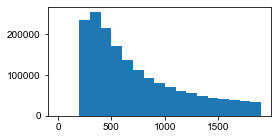

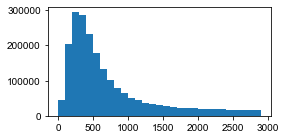

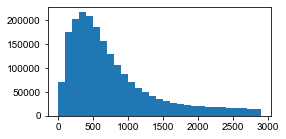

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 20 threads, in 103.231s
-- region kept: 0.7462
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 20 threads, in 82.797s
-- collapse all regions into 1d.


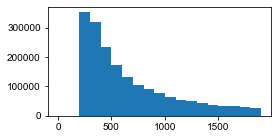

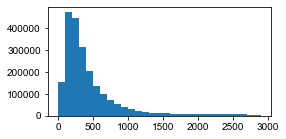

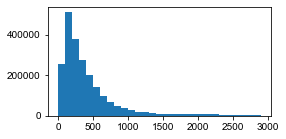

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 20 threads, in 101.958s
-- region kept: 0.9261
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 20 threads, in 82.475s
-- collapse all regions into 1d.


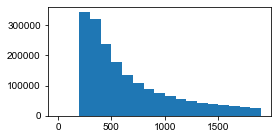

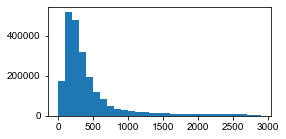

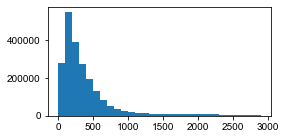

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 20 threads, in 101.137s
-- region kept: 0.9774
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 20 threads, in 82.324s
-- collapse all regions into 1d.


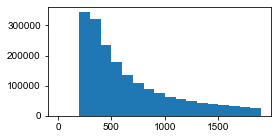

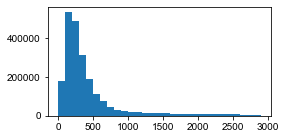

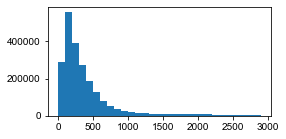

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 20 threads, in 102.333s
-- region kept: 0.9902
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 20 threads, in 83.403s
-- collapse all regions into 1d.


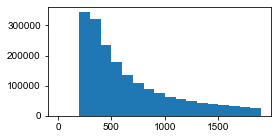

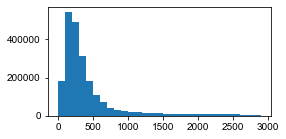

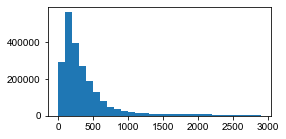

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 20 threads, in 101.793s
-- region kept: 0.9947
- iter:5
- generate reference metrics from picked chrs.
-- multiprocessing process references with 20 threads, in 82.991s
-- collapse all regions into 1d.


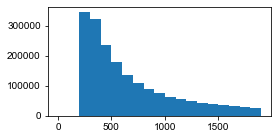

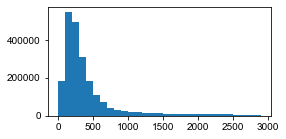

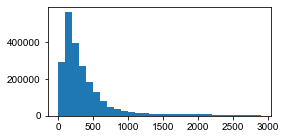

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 20 threads, in 102.738s
-- region kept: 0.9967


In [14]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 20
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

In [16]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
distmap_list = []
score_th = np.exp(-6)
bad_spot_percentage = 0.6
for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _kept_hzxys[_scores < score_th] = np.nan
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

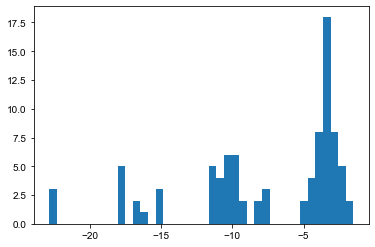

In [17]:
plt.figure()
plt.hist(np.log(sel_dna_scores_list[sel_iter][1]), 40)
plt.show()

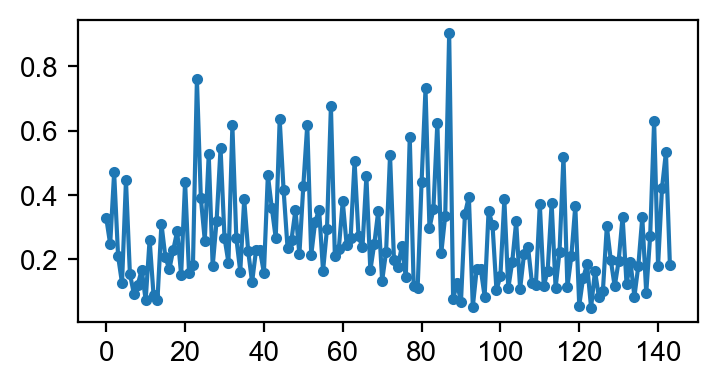

In [18]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [27]:
dna_reg_ids[53]

95

In [ ]:
fov.uni

In [ ]:
cy3_inds = np.where()

<IPython.core.display.Javascript object>


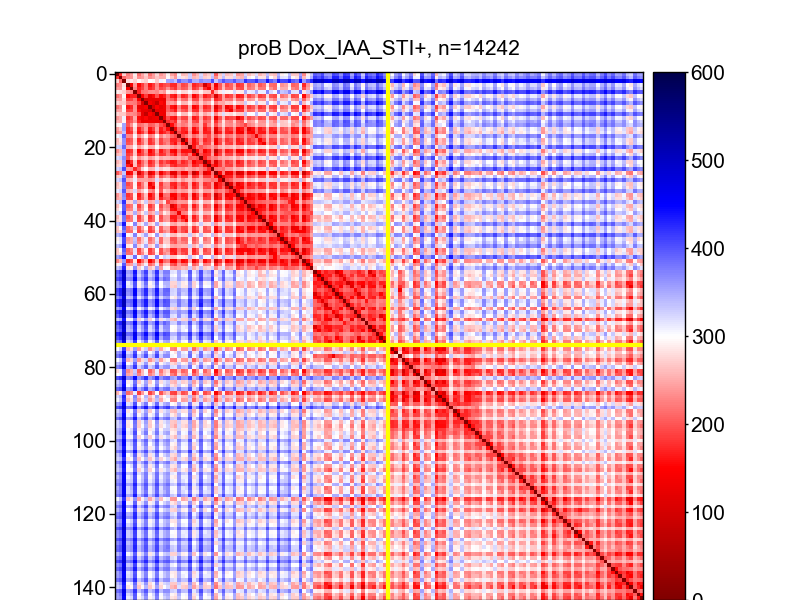

In [39]:
%matplotlib notebook
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.axvline(x=74, color=[1,1,0])
ax.axhline(y=74, color=[1,1,0])
ax.set_title(f"proB Dox_IAA_STI+, n={len(distmap_list)}", fontsize=7.5)
plt.show()

C:\Users\puzheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic_r"))
  if sys.path[0] == '':


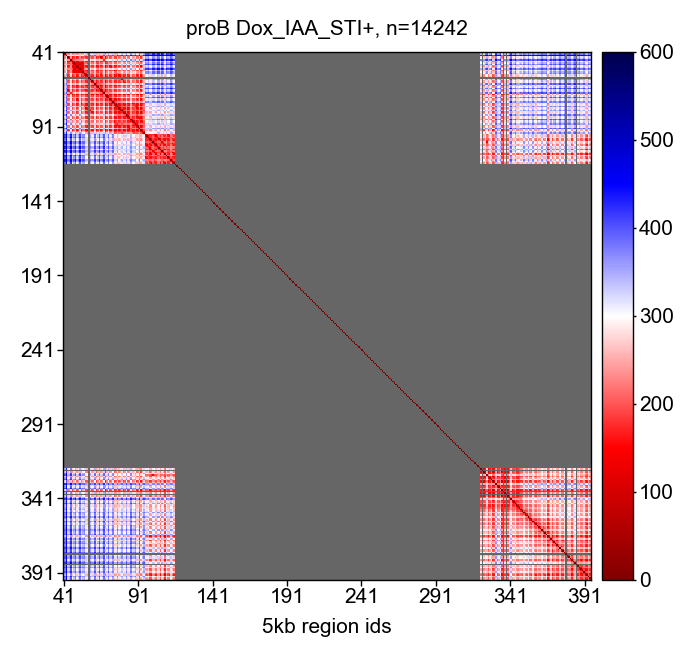

In [24]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    

import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"proB Dox_IAA_STI+, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

###### 

C:\Users\puzheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic_r"))
  


<IPython.core.display.Javascript object>


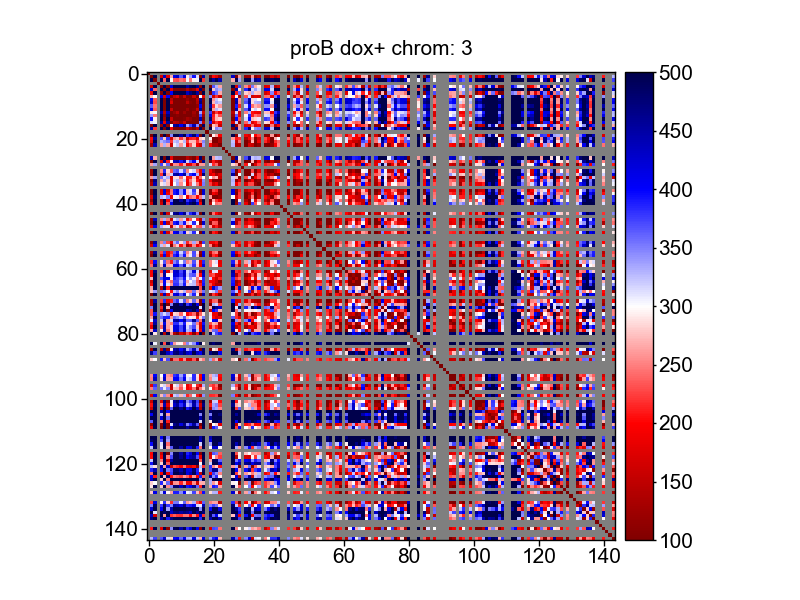

<IPython.core.display.Javascript object>


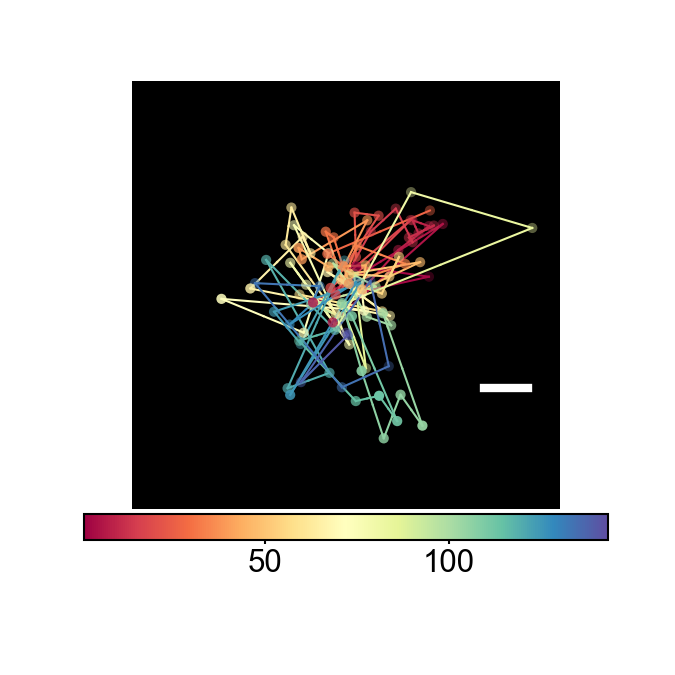

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000001FF3A2C8C88>


In [37]:
%matplotlib notebook
chrom_id = 3

import matplotlib
sc_cmap = matplotlib.cm.get_cmap('seismic_r')
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])


valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(distmap_list[chrom_id],
                                               #distmap_list[chrom_id][valid_inds][:,valid_inds], 
                                               cmap=sc_cmap,
                                               color_limits=[100,500],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB dox+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()



reload(figure_tools.image)
ax3d = figure_tools.image.chromosome_structure_3d_rendering(final_dna_hzxys_list[chrom_id][:,1:], 
                                                     #final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
                                                     marker_edge_line_width=0,
                                                     reference_bar_length=100, image_radius=200, 
                                                     line_width=0.5, figure_dpi=300, depthshade=True)
plt.show()

# quality check

In [125]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    _ind = list(_grp['ids'][:]).index(41)
    _im = _grp['ims'][_ind]
    sel_drifts = _grp['drifts'][:,:]
    sel_flags = _grp['flags'][:]
    sel_ids = _grp['ids'][:]
    sel_spots = _grp['spots'][:,:,:]
    print(_ind, np.sum(_grp['spots'][1]))

0 3826469.0


In [58]:
fov.unique_spots_list[100]

array([[ 6.56082726e+00,  2.59606991e+01,  6.11601379e+02, ...,
         7.73071229e-01, -3.07731796e-02,  1.70267914e+02],
       [ 4.22157383e+00,  2.32151070e+01,  9.43703918e+02, ...,
         4.81479615e-01,  6.38460398e-01,  1.23589035e+02],
       [ 3.96723986e+00,  2.77801933e+01,  7.93457642e+02, ...,
         7.53727496e-01,  9.04093564e-01,  1.02488930e+02],
       ...,
       [ 1.36868820e-01,  2.36938343e+01,  5.36140991e+02, ...,
         1.00000000e+00,  1.00000000e+00,  3.58169556e+01],
       [ 1.75873071e-01,  1.39472771e+01,  1.97251758e+03, ...,
        -2.08728582e-01, -6.80764616e-02,  3.75798035e+01],
       [ 1.79312319e-01,  2.28999996e+01,  8.71613098e+02, ...,
        -1.00000000e+00, -1.00000000e+00,  3.54034157e+01]], dtype=float32)

<IPython.core.display.Javascript object>


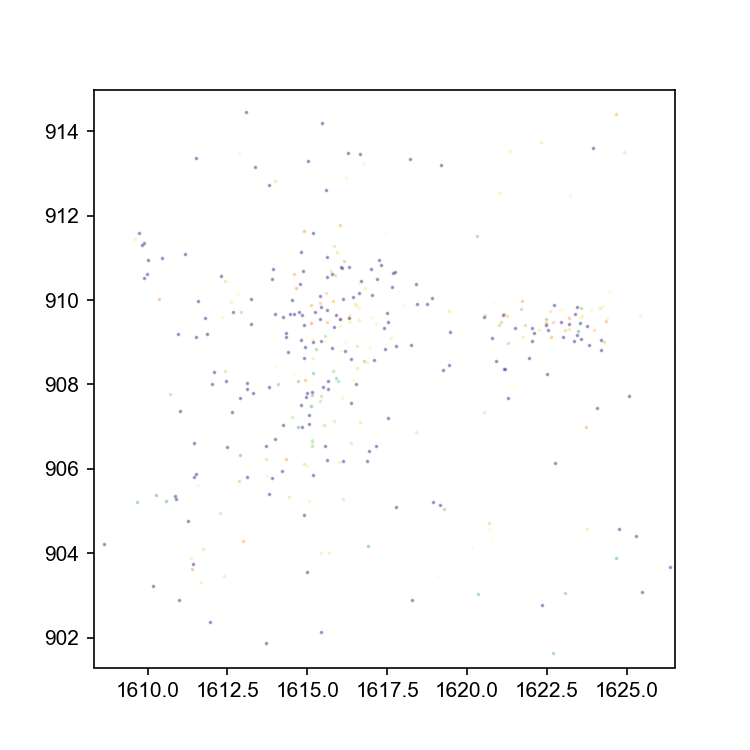

In [145]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)
for _id,_s in zip(sel_ids, kept_spots_list):
    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
plt.ylim([0,2048])
plt.xlim([0,2048])
#plt.legend()
plt.show()

array([[0.98592849, 0.63737024, 0.35963091, 1.        ],
       [0.98869666, 0.65736255, 0.36885813, 1.        ],
       [0.99146482, 0.67735486, 0.37808535, 1.        ],
       [0.99238754, 0.69388697, 0.39008074, 1.        ],
       [0.99269512, 0.70926567, 0.40299885, 1.        ],
       [0.9928489 , 0.71695502, 0.4094579 , 1.        ],
       [0.99315648, 0.73233372, 0.42237601, 1.        ],
       [0.99346405, 0.74771242, 0.43529412, 1.        ],
       [0.99377163, 0.76309112, 0.44821223, 1.        ],
       [0.99392541, 0.77078047, 0.45467128, 1.        ],
       [0.99423299, 0.78615917, 0.46758939, 1.        ],
       [0.99454056, 0.80153787, 0.4805075 , 1.        ],
       [0.99484814, 0.81691657, 0.49342561, 1.        ],
       [0.99515571, 0.83229527, 0.50634371, 1.        ],
       [0.9953095 , 0.83998462, 0.51280277, 1.        ],
       [0.99561707, 0.85536332, 0.52572088, 1.        ],
       [0.99592464, 0.87074202, 0.53863899, 1.        ],
       [0.99638601, 0.88796617,

## visualize pciked hzxys

<IPython.core.display.Javascript object>


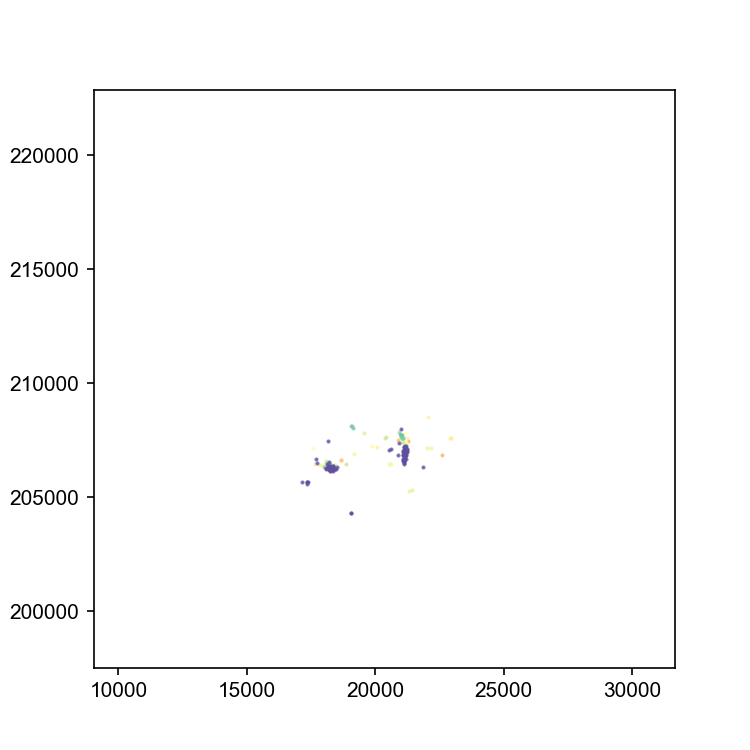

In [146]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)

for _i, _id in enumerate(sel_ids):
    plt.plot([_spots[_i,2] for _spots in final_dna_hzxys_list],
             [_spots[_i,3] for _spots in final_dna_hzxys_list],
             '.', markersize=2, color=Spectral(_id/(len(sel_ids)+1)), alpha=0.7)
#for _id,_s in zip(sel_ids, kept_spots_list):
#    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
#             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
#plt.ylim([0,2048])
#plt.xlim([0,2048])
#plt.legend()
plt.show()

## visualize fitted spots

<IPython.core.display.Javascript object>


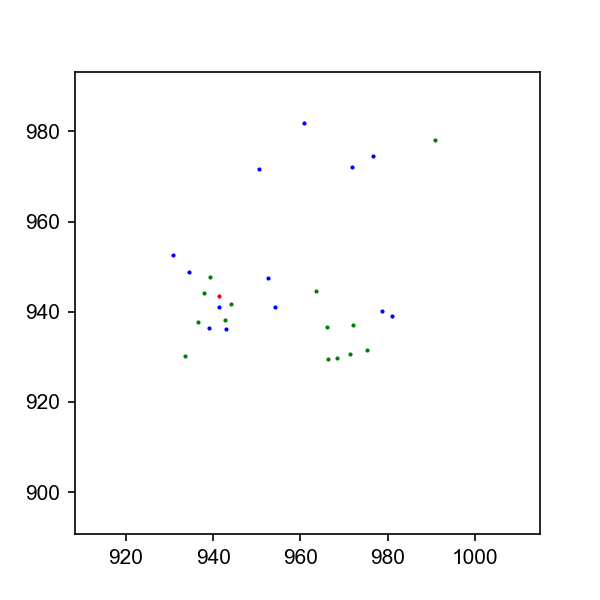

In [28]:
plt.figure(figsize=(4,4),dpi=150)
plt.plot(fov.chrom_coords[:,1], fov.chrom_coords[:,2], 'r.', markersize=2)
plt.plot(fov.unique_spots_list[0][:,2], fov.unique_spots_list[0][:,3], 'b.', markersize=2)
plt.plot(fov.unique_spots_list[-1][:,2], fov.unique_spots_list[-1][:,3], 'g.', markersize=2)

In [84]:
sel_drifts[kept_inds]

array([[ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2

In [86]:
sel_drifts[kept_inds]

array([[  0.46, -16.34,  16.85],
       [  0.46, -16.34,  16.85],
       [  0.44,  -8.16,  14.05],
       [  0.44,  -8.16,  14.05],
       [  2.29,  -2.57,  15.59],
       [  2.29,  -2.57,  15.59],
       [  2.35,   8.53,  14.83],
       [  2.35,   8.53,  14.83],
       [  2.31,   6.76,  13.09],
       [  2.31,   6.76,  13.09],
       [  0.44, -15.23,  17.16],
       [  0.44, -15.23,  17.16],
       [  2.33, -16.8 ,  17.91],
       [  2.33, -16.8 ,  17.91],
       [  0.46, -16.95,  17.39],
       [  0.46, -16.95,  17.39],
       [  0.44, -18.39,  20.26],
       [  0.44, -18.39,  20.26],
       [  0.42, -18.18,  18.52],
       [  0.42, -18.18,  18.52],
       [  0.41, -18.32,  17.25],
       [  0.41, -18.32,  17.25],
       [  0.41, -17.91,  18.16],
       [  0.41, -17.91,  18.16],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.62,  16.99],
       [  0.41, -18.62,  16.99],
       [  0.42, -18.41,  17.88],
       [  0.42, -18.41,  17.88],
       [  

In [93]:
fov.fov_id

5

In [118]:
pickle.load(open(fov.drift_filename, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '\\\\10.245.74.158\\Chromatin_NAS_6\\20201002-B_dox-IAA-STI+_CTP-08_IgH\\Analysis\\drift\\Conv_zscan_05_current_cor.pkl'

In [101]:
bead_im, _ = io_tools.load.correct_fov_image(os.path.join(fov.data_folder[0], 'H29R29\\Conv_zscan_05.dax'), 
                                             [fov.channels[fov.bead_channel_index]],
                                             correction_folder=fov.correction_folder,
                                             single_im_size=fov.shared_parameters['single_im_size'],
                                             all_channels=fov.channels,
                                             illumination_corr=True, 
                                             warp_image=False, calculate_drift=False, return_drift=False,
                                             verbose=True,
                                             )

- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax  in 8.028s
-- removing hot pixels for channels:['488'] in 7.301s
-- illumination correction for channels: 488, in 1.663s
-- generate translation function for chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.001s
-- finish correction in 17.336s


In [109]:
correction_tools.alignment.cross_correlation_align_single_image(bead_im[0], fov.ref_im,
                                                                single_im_size=fov.shared_parameters['single_im_size'])

-- aligning image -> directly use image
-- directly use ref_image


array([-0.09, -9.87,  6.47])

<IPython.core.display.Javascript object>


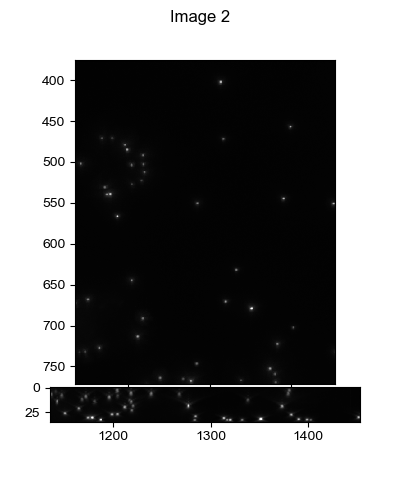

In [106]:
visual_tools.imshow_mark_3d_v2([bead_im[0], fov.ref_im])